**Задание.**

Разработать собственную программу на языке Python для классификации данных с использованием перцептрона. Необходимо найти оптимальное число нейронов на скрытом слое, обеспечивающее наиболее высокую точность классификации. Использовать набор данных, соответствующий Вашему варианту (название файла с данными Y.csv, где Y – номер варианта). Имя класса указанно в столбце class. Обучить перцептрон на всех доступных признаках. Номер варианта указан в задании к лабораторной работе №1.


**Результаты, которые необходимо получить в итоге:**

1. Количество нейронов на скрытом слое, обеспечивающих необходимую точность.
2. Графики зависимости значений точности и функции потерь от эпохи обучения для обоих перцептронов.
3. Выводы о связности числа признаков и нейронов на скрытом слое.

**Процесс выполнения работы**

Сначала был произведен первичный анализ данных: построение распределений для признаков и боксплоты для поверхностного просмотра наличия аномальных значений. В результате было определено, что довольно большое количество признаков содержат выбросы, что может сказаться на качестве работы модели.

Проблема с выбросами в признаках будет решаться масштабированием признаков: Robust, Normalizer. Кроме основной модели, построенной на всех признаках, исследовались еще 2 модели: одна с признаками, полученными в результате отбора, вторая - с использованием PCA (для них признаки были масштабированы только Robust). 

Модель написана с использованием Keras. Поиск нейронов на скрытом слое осуществлялся с помощью RandomSearch.

Для моделей строились графики точности и функции потерь от эпохи обучения.

Точность высчитывалась для тестовой выборки, тренировочной выборки и всех данных. 


In [25]:
import numpy as np
np.random.seed(0)
import pandas as pd
pd.set_option('display.max_columns', None)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style(style="darkgrid")
sns.set_palette(palette=sns.color_palette("ch:.25",15))
# color palette for seaborn
cmap = sns.diverging_palette(220, 10, as_cmap=True)
import warnings
warnings.simplefilter(action='ignore')

# EDA

In [26]:
data  = pd.read_csv('Lab5_Data.csv')
data.head()

,class,X_0,Y_0,X_1,Y_1,X_2,Y_2,X_3,Y_3,X_4,Y_4,X_5,Y_5,X_6,Y_6,X_7,Y_7,X_8,Y_8,X_9,Y_9,X_10,Y_10,X_11,Y_11,X_12,Y_12,X_13,Y_13,X_14,Y_14,X_15,Y_15,X_16,Y_16,X_17,Y_17,X_18,Y_18,X_19,Y_19,X_20,Y_20,X_21,Y_21,X_22,Y_22,X_23,Y_23
0,1,291.6,515.7,297.0,372.6,310.5,294.3,280.8,291.6,332.1,310.5,259.2,307.8,364.5,410.4,224.1,402.3,399.6,510.3,183.6,499.5,413.1,610.2,170.1,594.0,337.5,631.8,243.0,626.4,342.9,810.0,224.1,810.0,351.0,982.8,218.7,969.3,388.8,1026.0,197.1,1017.9,386.1,661.5,399.6,669.6,191.7,650.7,178.2,656.1
1,1,294.3,515.7,297.0,372.6,310.5,297.0,280.8,294.3,329.4,310.5,256.5,310.5,367.2,410.4,224.1,399.6,407.7,504.9,175.5,491.4,418.5,588.6,170.1,575.1,337.5,631.8,245.7,621.0,342.9,812.7,226.8,807.3,351.0,982.8,218.7,969.3,388.8,1028.7,199.8,1017.9,388.8,634.5,407.7,642.6,197.1,621.0,178.2,629.1
2,1,294.3,515.7,294.3,369.9,310.5,294.3,280.8,291.6,332.1,310.5,259.2,307.8,367.2,407.7,224.1,399.6,415.8,499.5,162.0,491.4,415.8,561.6,189.0,548.1,340.2,629.1,248.4,621.0,345.6,812.7,226.8,807.3,351.0,982.8,218.7,969.3,391.5,1028.7,197.1,1017.9,380.7,594.0,402.3,612.9,221.4,575.1,199.8,588.6
3,1,294.3,518.4,294.3,369.9,310.5,294.3,280.8,291.6,332.1,310.5,259.2,307.8,367.2,407.7,224.1,399.6,415.8,499.5,162.0,494.1,415.8,561.6,189.0,548.1,340.2,629.1,245.7,621.0,345.6,812.7,226.8,807.3,351.0,982.8,218.7,969.3,388.8,1026.0,197.1,1020.6,383.4,594.0,402.3,612.9,221.4,577.8,199.8,588.6
4,1,291.6,521.1,294.3,372.6,307.8,297.0,278.1,291.6,329.4,313.2,256.5,307.8,367.2,405.0,221.4,399.6,432.0,488.7,151.2,483.3,383.4,529.2,221.4,483.3,337.5,631.8,245.7,631.8,345.6,810.0,226.8,810.0,351.0,982.8,218.7,969.3,388.8,1026.0,197.1,1020.6,334.8,540.0,351.0,569.7,272.7,504.9,251.1,518.4


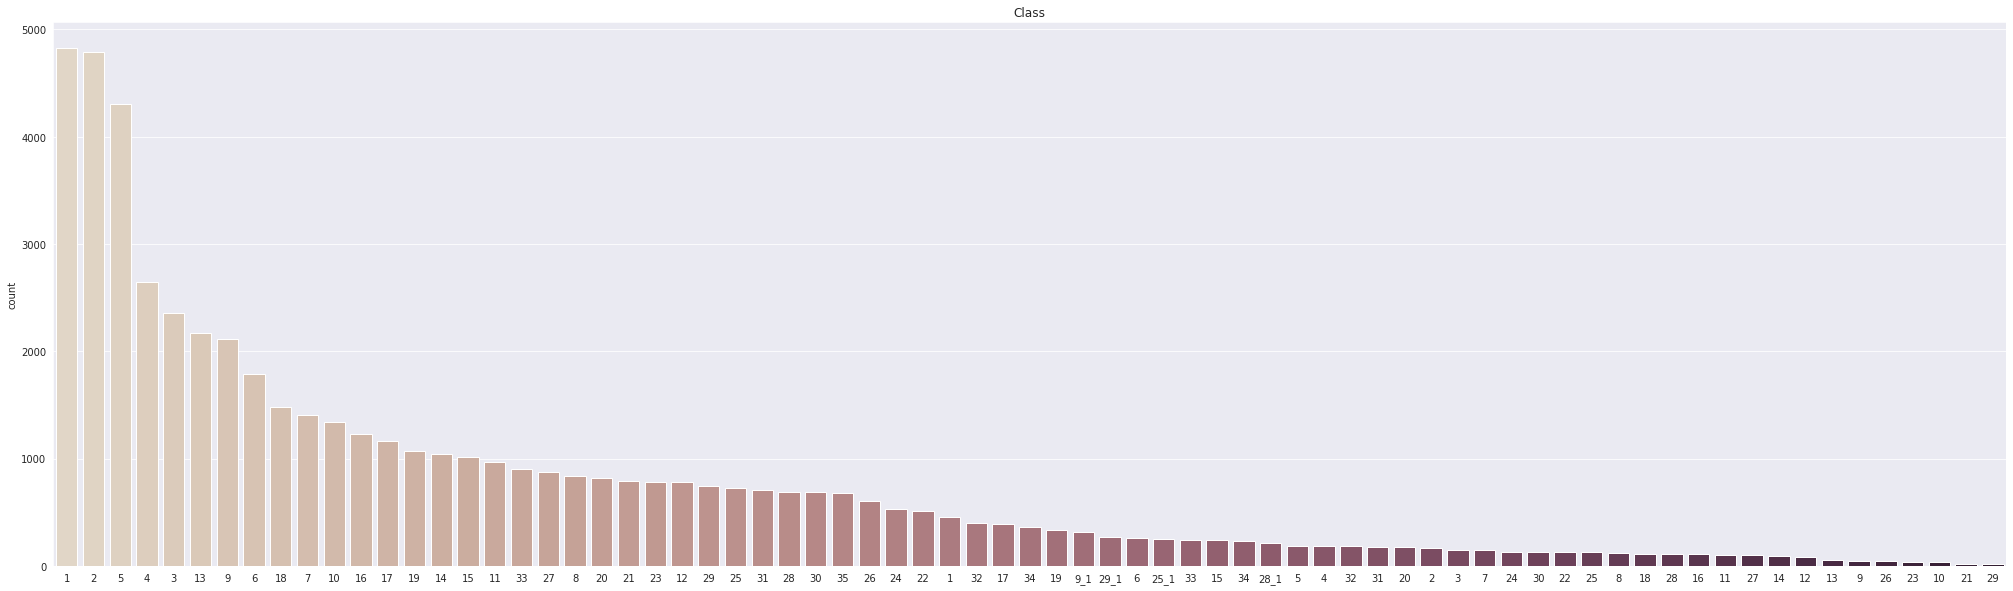

In [3]:
fig, ax = plt.subplots(figsize=(35,10))

class_count = data['class'].value_counts().sort_values(ascending=False).to_frame()
class_count = class_count.rename(columns={'class': 'count'})
sns.barplot(x=class_count.index, y='count', data=class_count,  palette="ch:.25")

ax = ax.set_title('Class')

Во-первых, видим странное именование классов: 9_1, 29_1, 25_1, 28_1.  Также у нас встречается дважды класс 1, например. Предобработаем:

In [27]:
data['class'].loc[data['class'] == '9_1'] = 36
data['class'].loc[data['class'] == '29_1'] = 37
data['class'].loc[data['class'] == '25_1'] = 38
data['class'].loc[data['class'] == '28_1'] = 39

data['class'] = pd.to_numeric(data['class'])

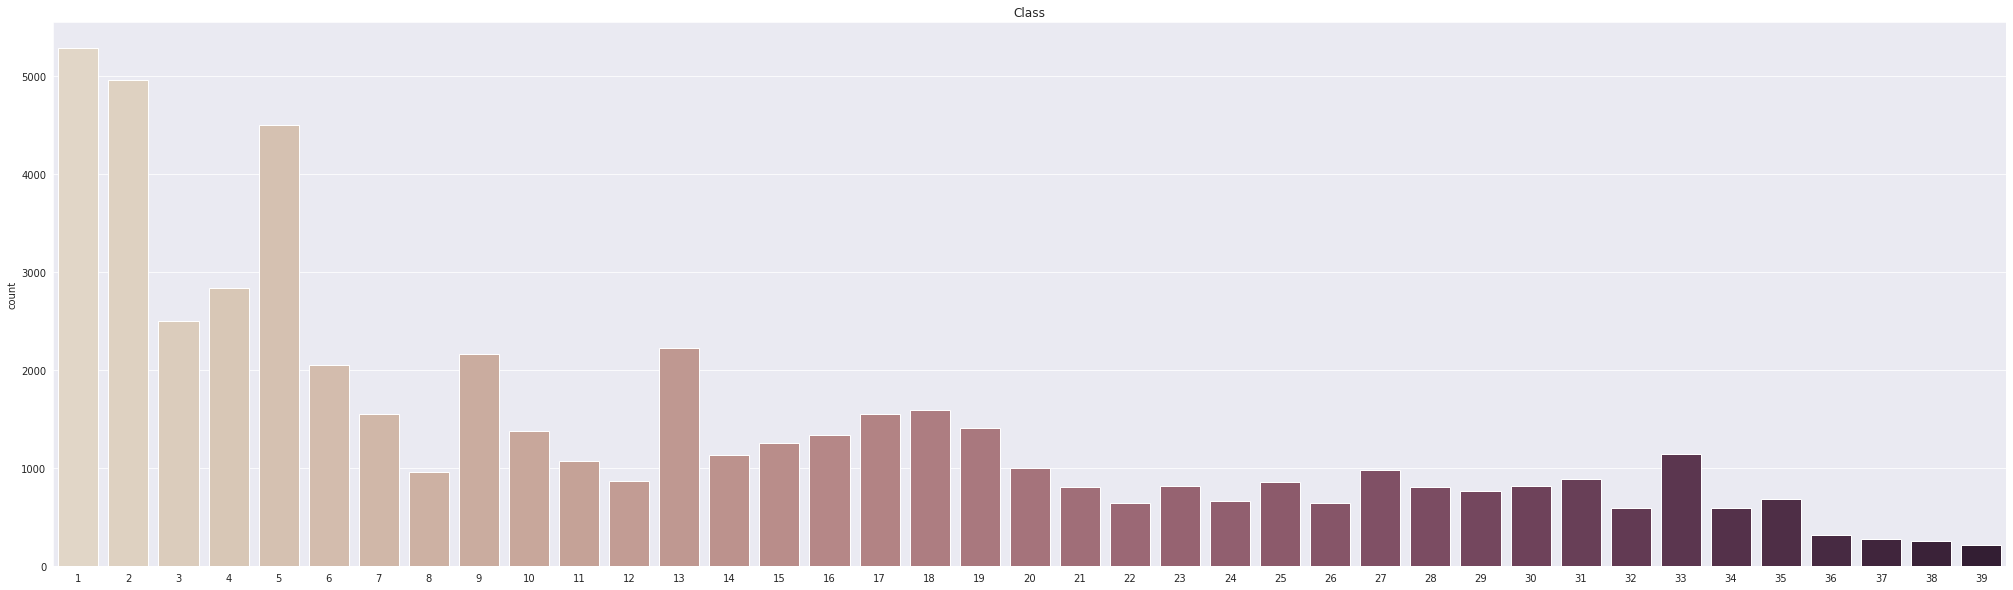

In [5]:
fig, ax = plt.subplots(figsize=(35,10))

class_count = data['class'].value_counts().sort_values(ascending=False).to_frame()
class_count = class_count.rename(columns={'class': 'count'})
sns.barplot(x=class_count.index, y='count', data=class_count,  palette="ch:.25")

ax = ax.set_title('Class')

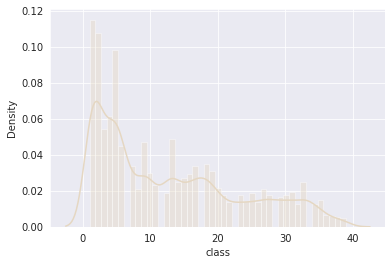

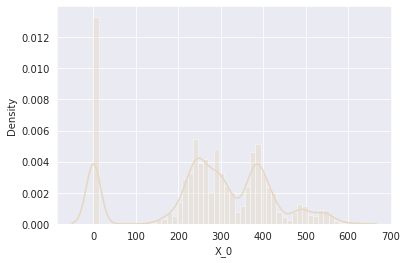

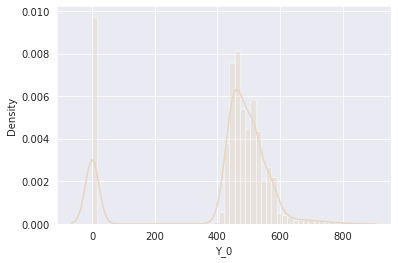

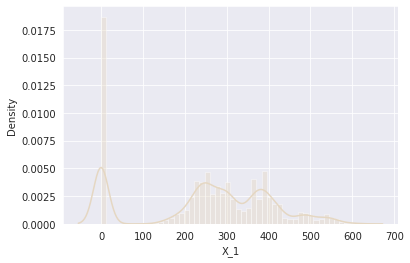

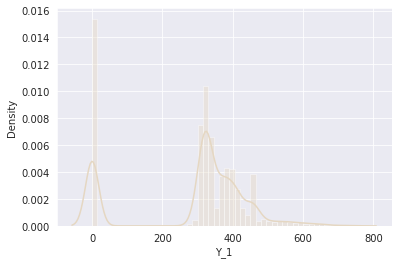

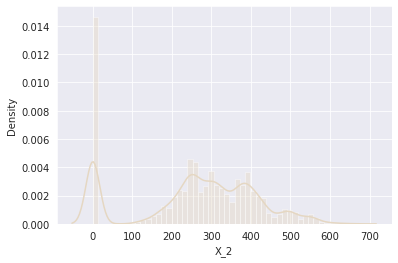

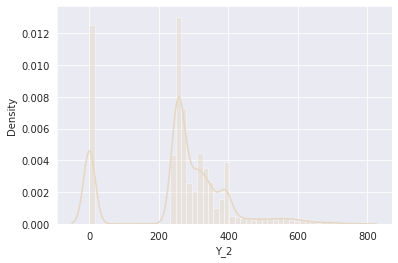

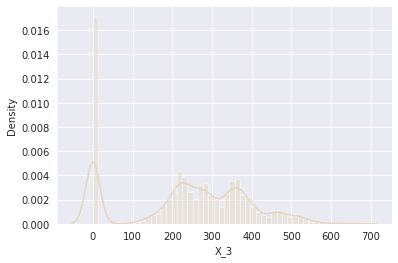

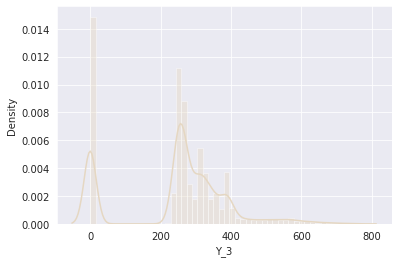

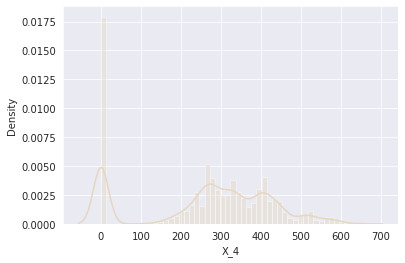

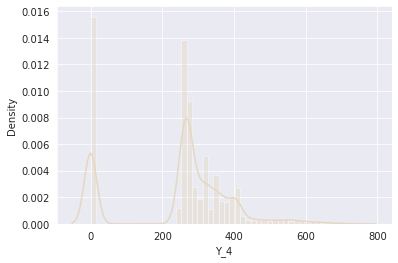

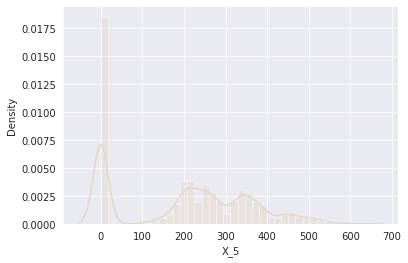

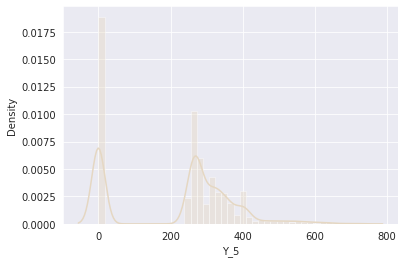

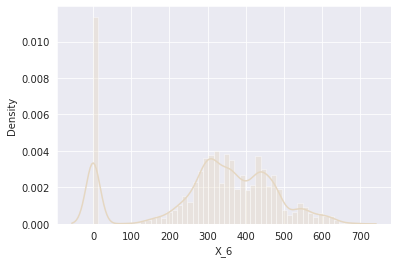

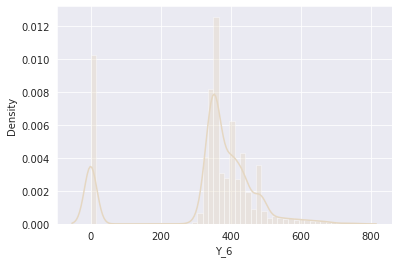

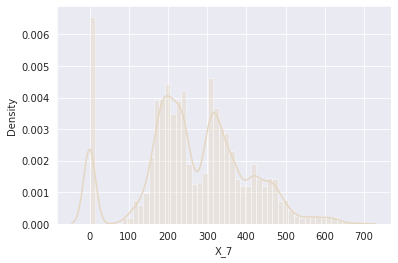

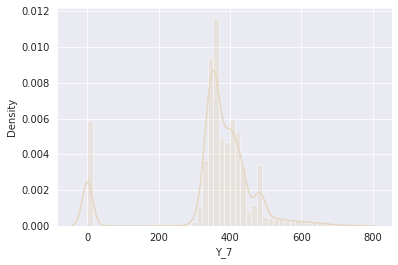

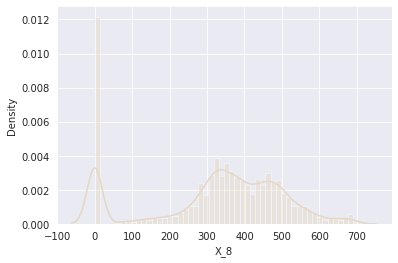

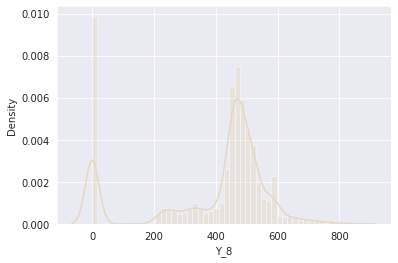

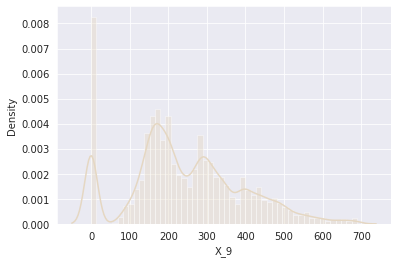

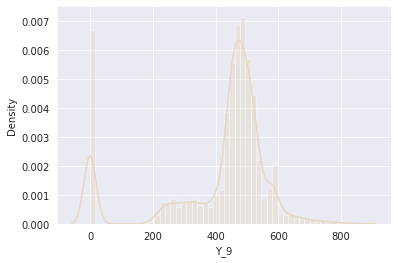

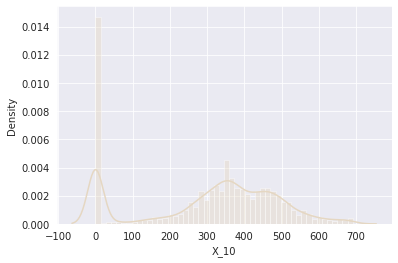

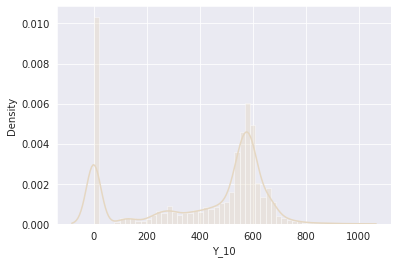

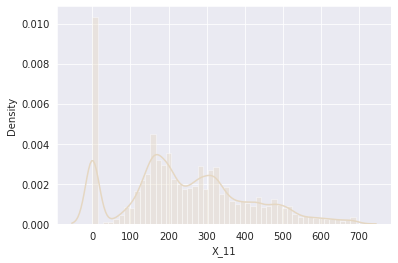

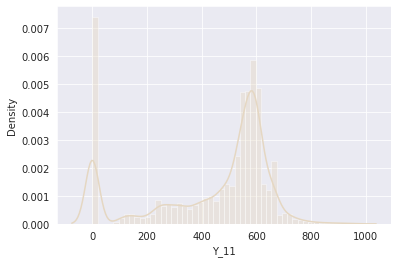

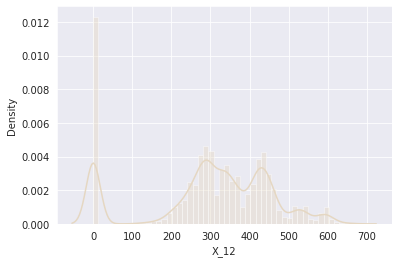

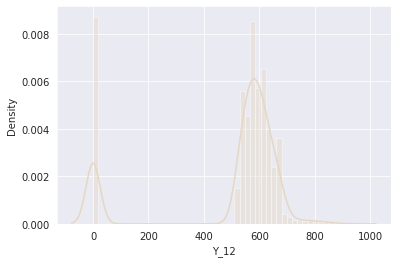

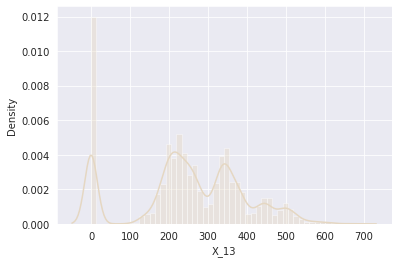

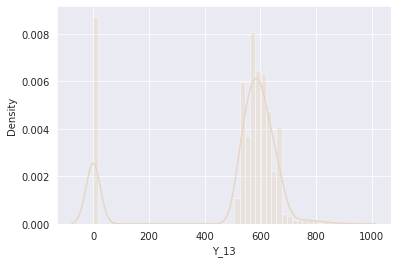

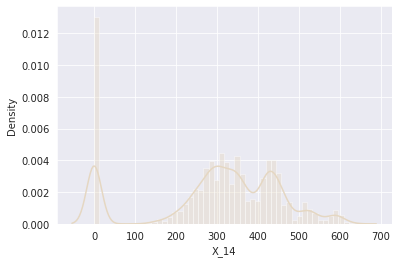

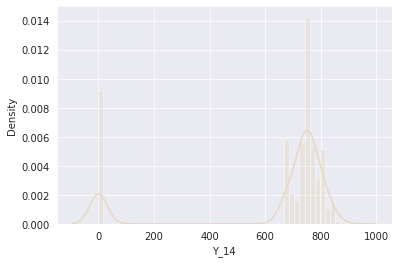

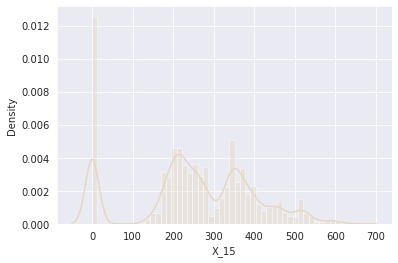

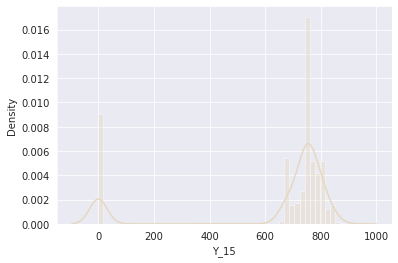

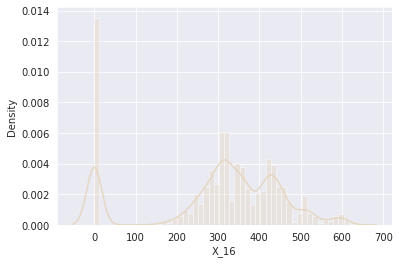

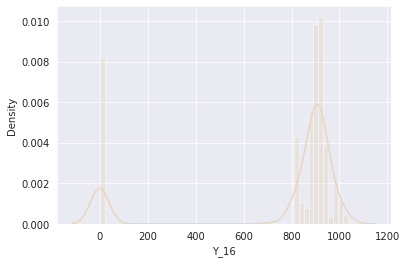

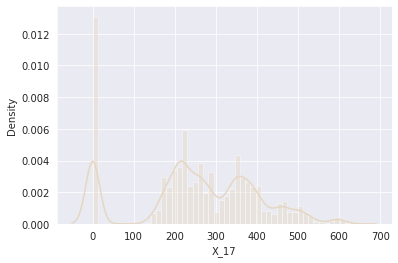

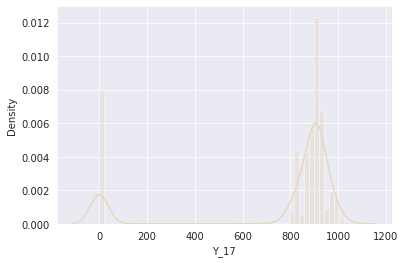

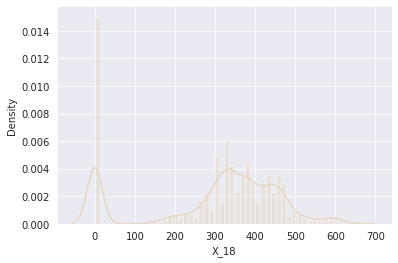

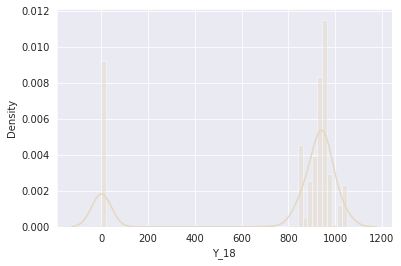

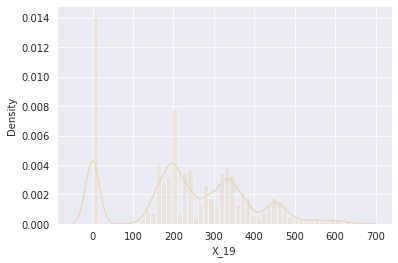

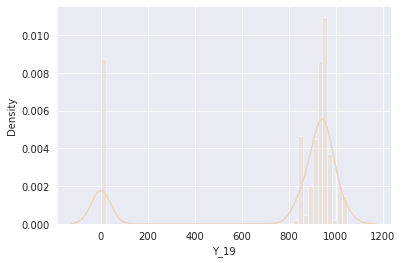

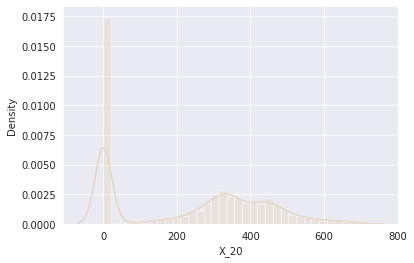

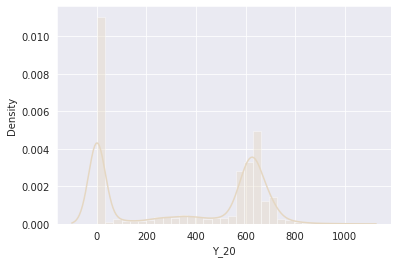

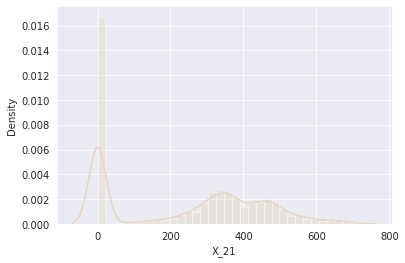

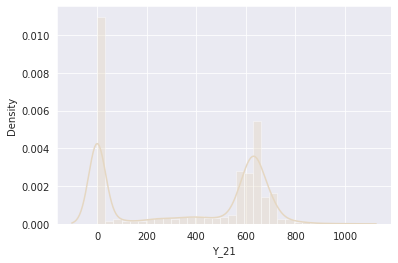

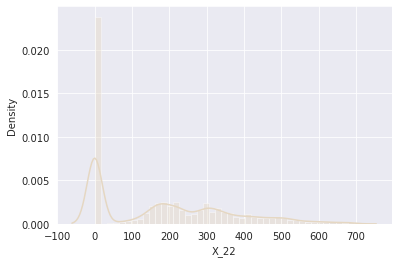

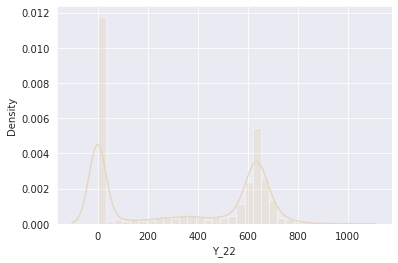

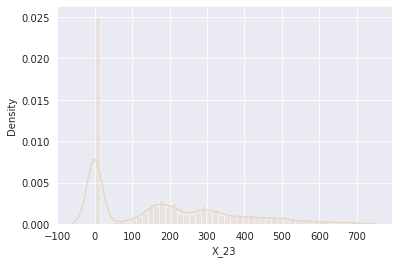

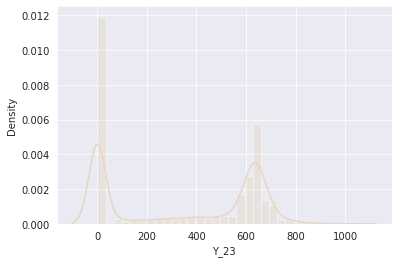

In [9]:
# посмотрим распределения в данных
for i, col in enumerate(data.columns):
    plt.figure(i)
    sns.distplot(data[col])

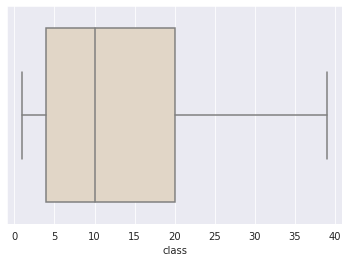

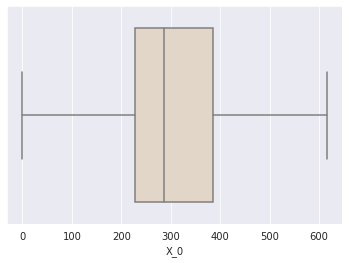

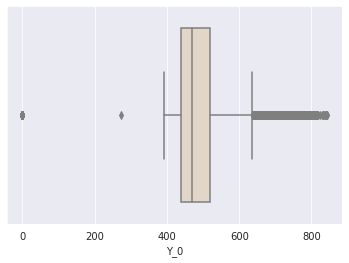

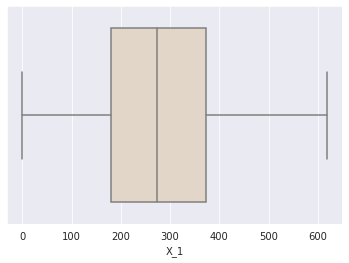

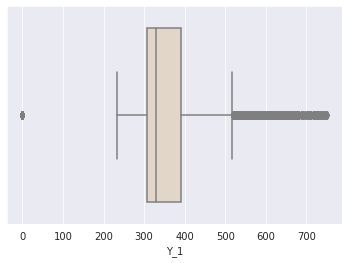

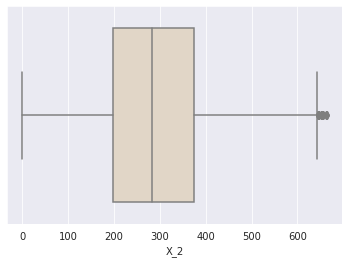

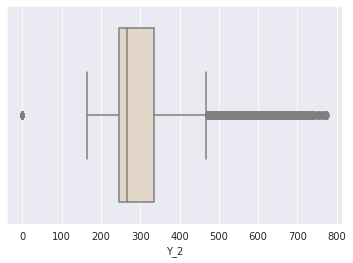

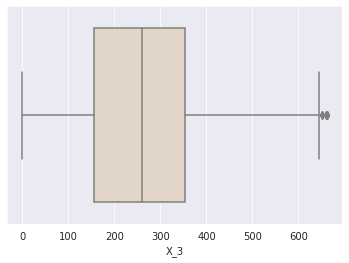

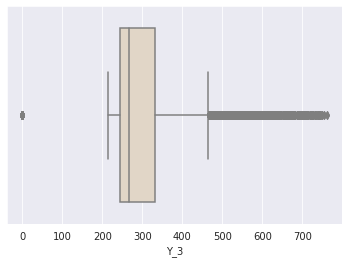

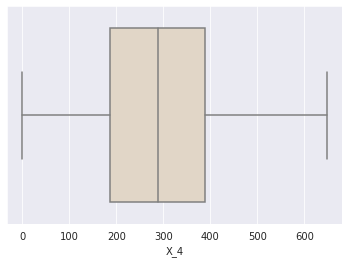

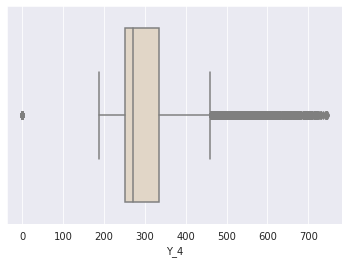

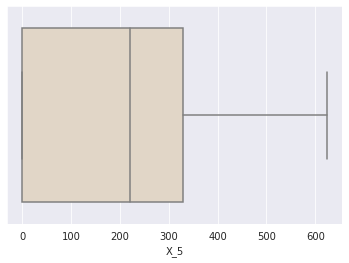

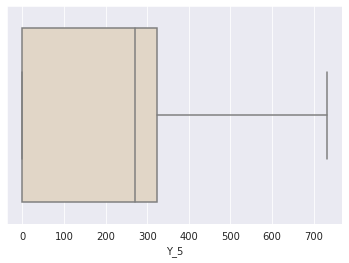

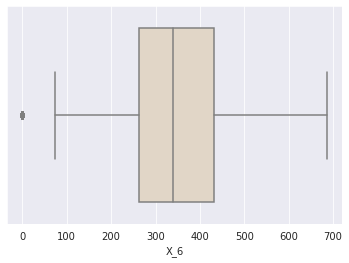

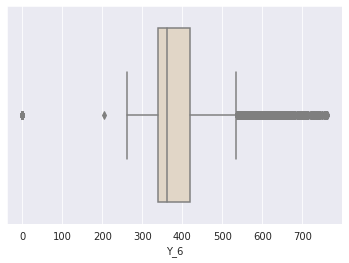

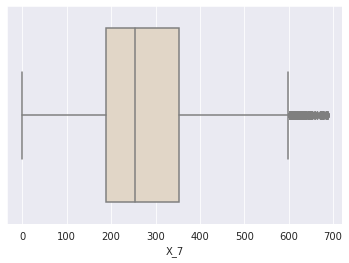

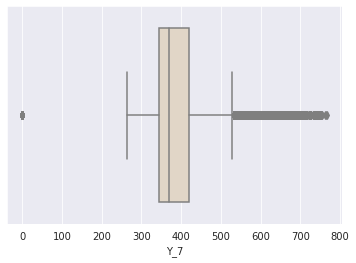

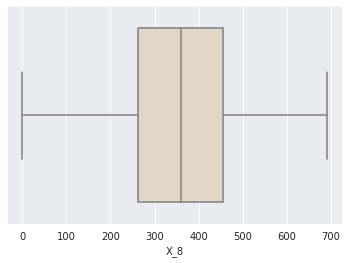

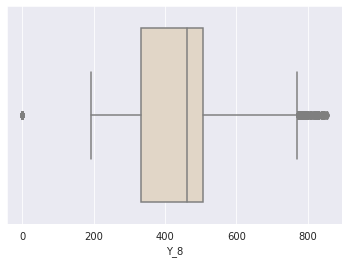

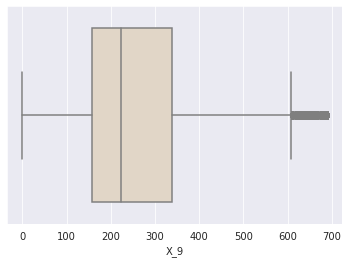

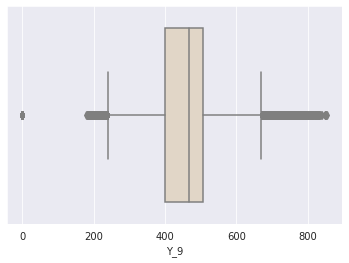

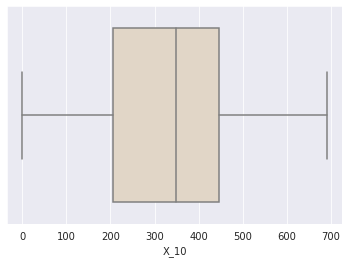

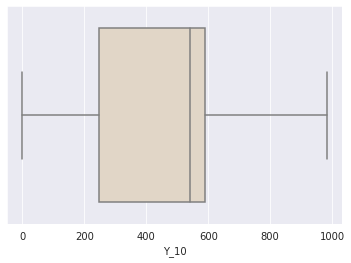

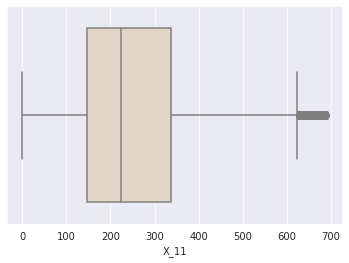

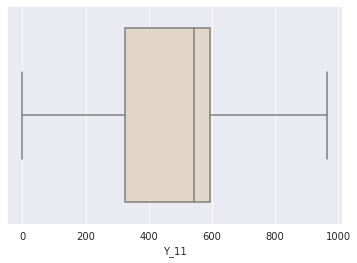

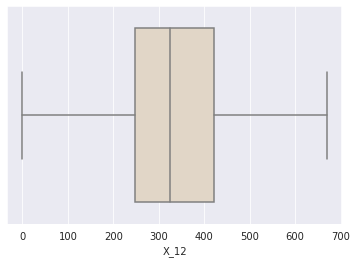

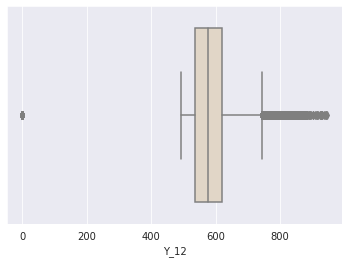

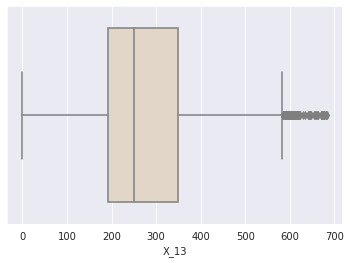

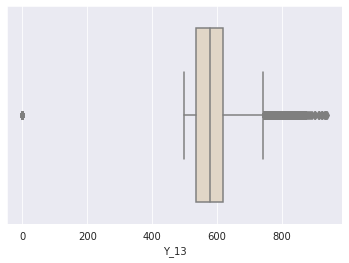

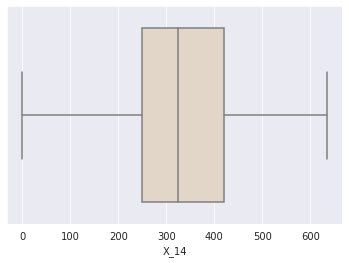

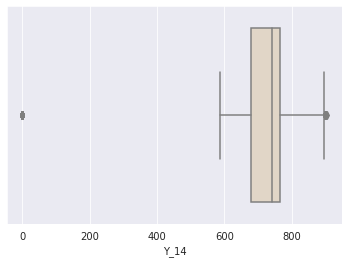

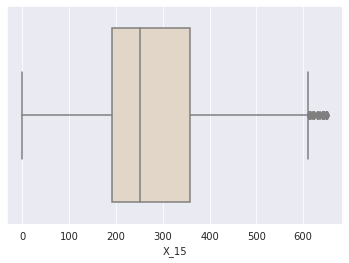

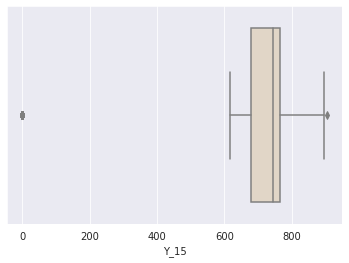

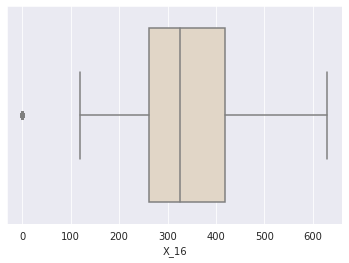

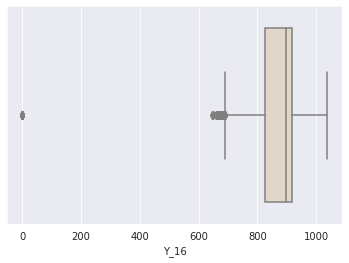

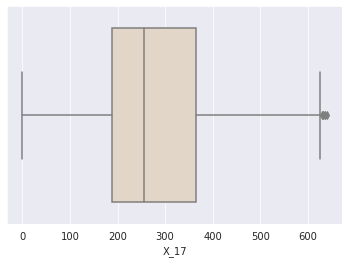

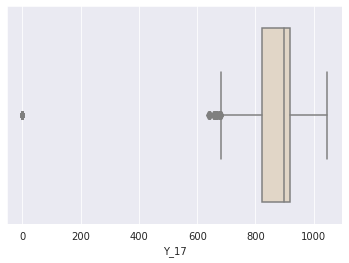

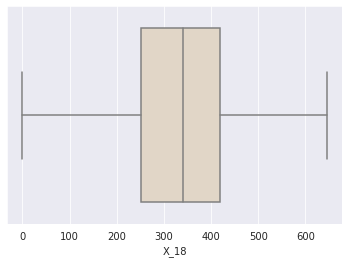

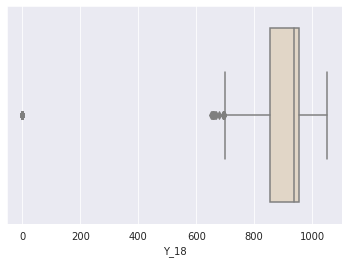

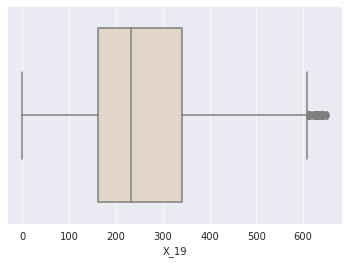

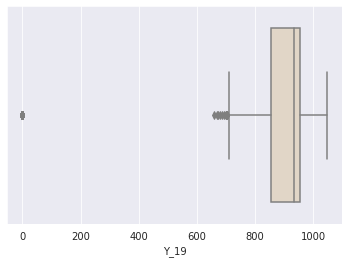

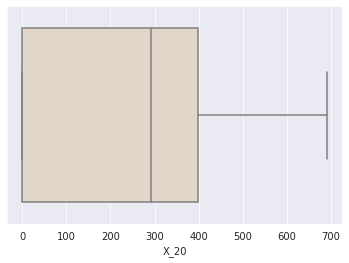

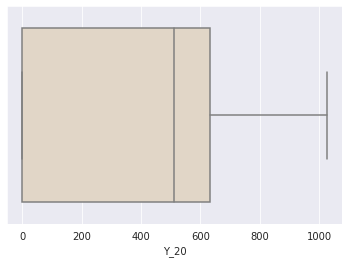

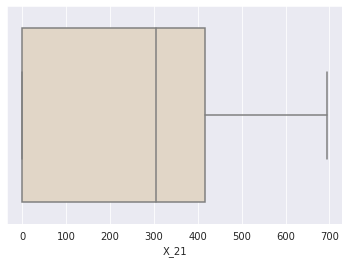

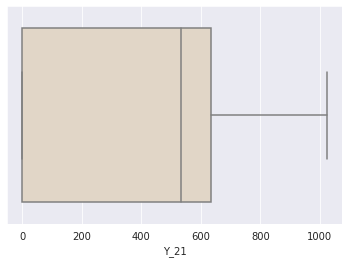

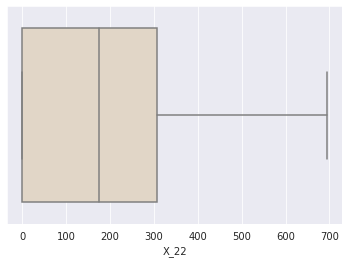

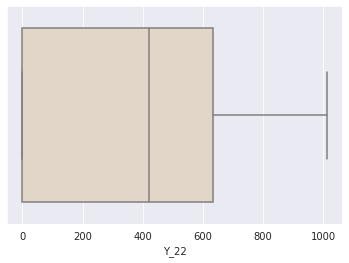

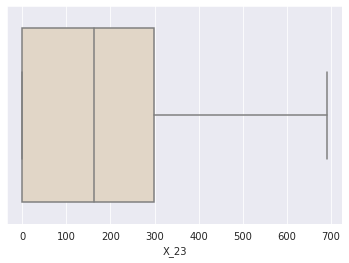

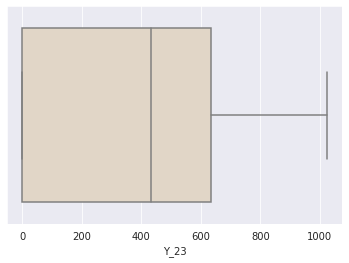

In [6]:
for i, col in enumerate(data.columns):
    plt.figure(i)
    sns.boxplot(data[col])

Boxplot - один из простых способов посмотреть на наличие выбросов в данных. Здесь видим выбросы в Y_19,X_19,Y_18,Y_17,X_17,Y_16,X_16,Y_15,X_15,Y_14,Y_13,X_13,Y_12,X_11,Y_9,Y_8,X_9,Y_7,X_7,Y_6,X_6,Y_4,Y_3,X_3,Y_2,X_2,Y_1,Y_0.

То есть достаточно много признаков, содержащих аномалии.

Самое важное, что можно сказать об  распределениях - много 0. Это могут быть как аномалии (выбросы), так и пропущенные значения, которые по каким-то причинам были записаны 0.

Есть несколько вариантов, что с этим можно сделать.

Во-первых, выбросить строки с аномалиями. Это довольно плохой подход, так как мы теряем большое количество данных. Во-вторых, провести масштабирование признаков, этот подход уже намного лучше, так как мы не теряем данные, а преобразовываем их. Но важно использовать алгоритм, который наименее чувствителен к выбросам, поэтому Standart scaler можно сразу отбрасывать, так как он базируется на mean/std, а на них влияют выбросы. MinMax тоже не выглядит как лучший вариант, так как он будет сжимать значения в одном диапазоне, учитывая значения выбросов. 

Попробуем несколько способов масштабирования и первый из них - Robust scaler, который основывается на квантилях, что делает его более устойчивым к выбросам.

In [4]:
from sklearn.preprocessing import RobustScaler

data.iloc[:, 1:] = RobustScaler().fit(data.iloc[:, 1:]).transform(data.iloc[:, 1:])
data.head()

,class,X_0,Y_0,X_1,Y_1,X_2,Y_2,X_3,Y_3,X_4,Y_4,X_5,Y_5,X_6,Y_6,X_7,Y_7,X_8,Y_8,X_9,Y_9,X_10,Y_10,X_11,Y_11,X_12,Y_12,X_13,Y_13,X_14,Y_14,X_15,Y_15,X_16,Y_16,X_17,Y_17,X_18,Y_18,X_19,Y_19,X_20,Y_20,X_21,Y_21,X_22,Y_22,X_23,Y_23
0,1,0.033898,0.586207,0.126761,0.516129,0.151515,0.303030,0.109589,0.272727,0.213333,0.483871,0.114754,0.116667,0.142857,0.620690,-0.180328,0.428571,0.208333,0.276923,-0.223881,0.300,0.269663,0.196850,-0.281690,0.19,0.078125,0.677419,-0.051724,0.580645,0.109375,0.78125,-0.161290,0.75000,0.155172,0.911765,-0.215385,0.742857,0.290323,0.868421,-0.196970,0.837838,0.236486,0.239316,0.227273,0.217021,0.052632,0.361702,0.054054,0.353191
1,1,0.050847,0.586207,0.126761,0.516129,0.151515,0.333333,0.109589,0.303030,0.200000,0.483871,0.106557,0.125000,0.158730,0.620690,-0.180328,0.392857,0.250000,0.246154,-0.268657,0.225,0.292135,0.133858,-0.281690,0.12,0.078125,0.677419,-0.034483,0.516129,0.109375,0.81250,-0.145161,0.71875,0.155172,0.911765,-0.215385,0.742857,0.290323,0.894737,-0.181818,0.837838,0.243243,0.196581,0.246753,0.174468,0.070175,0.314894,0.054054,0.310638
2,1,0.050847,0.586207,0.112676,0.483871,0.151515,0.303030,0.109589,0.272727,0.213333,0.483871,0.114754,0.116667,0.158730,0.586207,-0.180328,0.392857,0.291667,0.215385,-0.343284,0.225,0.280899,0.055118,-0.183099,0.02,0.093750,0.645161,-0.017241,0.516129,0.125000,0.81250,-0.145161,0.71875,0.155172,0.911765,-0.215385,0.742857,0.306452,0.894737,-0.196970,0.837838,0.222973,0.132479,0.233766,0.127660,0.149123,0.242553,0.126126,0.246809
3,1,0.050847,0.620690,0.112676,0.483871,0.151515,0.303030,0.109589,0.272727,0.213333,0.483871,0.114754,0.116667,0.158730,0.586207,-0.180328,0.392857,0.291667,0.215385,-0.343284,0.250,0.280899,0.055118,-0.183099,0.02,0.093750,0.645161,-0.034483,0.516129,0.125000,0.81250,-0.145161,0.71875,0.155172,0.911765,-0.215385,0.742857,0.290323,0.868421,-0.196970,0.864865,0.229730,0.132479,0.233766,0.127660,0.149123,0.246809,0.126126,0.246809
4,1,0.033898,0.655172,0.112676,0.516129,0.136364,0.333333,0.095890,0.272727,0.200000,0.516129,0.106557,0.116667,0.158730,0.551724,-0.196721,0.392857,0.375000,0.153846,-0.402985,0.150,0.146067,-0.039370,-0.014085,-0.22,0.078125,0.677419,-0.034483,0.645161,0.125000,0.78125,-0.145161,0.75000,0.155172,0.911765,-0.215385,0.742857,0.290323,0.868421,-0.196970,0.864865,0.108108,0.047009,0.110390,0.059574,0.315789,0.131915,0.297297,0.136170


# Features

## Correlation

In [57]:
corr = data.corr(method ='spearman')

top_corr = corr['class'].sort_values(ascending=False).to_frame()
table_corr = top_corr.style.background_gradient(cmap=cmap)
table_corr

,class
class,1.000000
X_7,0.245116
Y_23,0.232765
Y_22,0.226491
X_9,0.221300
X_22,0.220629
X_23,0.219124
X_11,0.205968
Y_11,0.160003
Y_9,0.151728


In [61]:
abs_corr = top_corr.apply(lambda row: abs(row))
abs_corr = abs_corr['class'].sort_values(ascending=False).to_frame()[:24]
corr_features = abs_corr.index.to_list()
corr_features 

['class',
 'X_7',
 'Y_23',
 'Y_22',
 'X_9',
 'X_22',
 'X_23',
 'X_11',
 'Y_11',
 'Y_9',
 'X_14',
 'X_0',
 'X_6',
 'X_12',
 'X_16',
 'X_13',
 'X_18',
 'X_8',
 'X_15',
 'Y_7',
 'Y_20',
 'X_17',
 'X_20',
 'Y_21']

## RFE

In [32]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [62]:
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=24, step=10, verbose=5)
rfe_selector.fit(data.iloc[:, 1:], data['class'])
rfe_support = rfe_selector.get_support()
rfe_features = data.drop(['class'], axis=1).loc[:,rfe_support].columns.tolist()
print('Топ-15 признаков, отобранных RFE: ', rfe_features)

Fitting estimator with 48 features.
Fitting estimator with 38 features.
Fitting estimator with 28 features.
Топ-15 признаков, отобранных RFE:  ['Y_0', 'X_4', 'X_6', 'X_7', 'X_8', 'Y_8', 'X_9', 'X_10', 'Y_10', 'X_11', 'Y_11', 'X_12', 'Y_12', 'X_13', 'Y_13', 'X_14', 'Y_14', 'X_15', 'X_16', 'X_19', 'Y_20', 'X_21', 'Y_22', 'Y_23']


In [63]:
selected_features = list(set(corr_features) & set(rfe_features))
selected_features

['X_12',
 'X_6',
 'X_8',
 'Y_22',
 'X_7',
 'X_14',
 'X_11',
 'X_15',
 'Y_20',
 'Y_11',
 'X_13',
 'Y_23',
 'X_16',
 'X_9']

## PCA

In [11]:
from sklearn.decomposition import PCA

n_comp = 24

pca_data = (PCA(n_components=n_comp, random_state=42).fit_transform(data.iloc[:, 1:]))
pca_data = pd.DataFrame(pca_data)
pca_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,-6.623331,0.189099,0.008619,-1.158387,-0.747451,-1.084088,0.919860,-0.052807,-0.284262,-0.081227,-0.180583,0.093010,-0.287032,0.039724,-0.114168,-0.156176,0.176952,0.070155,0.025264,-0.024969,0.008391,0.158876,-0.113951,0.013051
1,-6.619792,0.139958,0.064327,-1.098081,-0.746588,-1.072172,0.824054,-0.002063,-0.270258,-0.110902,-0.188587,0.121569,-0.314509,0.038641,-0.115561,-0.169509,0.170680,0.103348,0.080850,-0.004868,0.011963,0.100756,-0.080300,-0.026898
2,-6.588630,0.076637,0.022554,-1.050131,-0.748529,-1.044240,0.752390,-0.025149,-0.245402,-0.147923,-0.198525,0.168487,-0.347591,0.088549,-0.180005,-0.192329,0.137872,0.121039,0.081372,-0.001471,-0.019022,0.041397,-0.046434,-0.098687
3,-6.595497,0.083969,0.010446,-1.070580,-0.717182,-1.047376,0.764882,-0.031916,-0.248229,-0.151797,-0.202208,0.173313,-0.331714,0.074586,-0.182440,-0.199204,0.134038,0.127133,0.084076,0.001957,-0.029820,0.034622,-0.063888,-0.104985
4,-6.615703,-0.002038,0.003663,-1.052751,-0.665568,-0.891568,0.545282,-0.033455,-0.201780,-0.174861,-0.136567,0.333260,-0.427026,0.170601,-0.328313,-0.238205,0.045079,0.074752,0.020881,0.021835,-0.136123,-0.014037,-0.041315,-0.211471


# Train-test

In [28]:
labels = to_categorical(data['class'])

In [64]:
# RobustScaler
X_train, X_test, Y_train, Y_test = train_test_split(data.iloc[:, 1:], labels, test_size=.3, random_state=0)
# PCA
X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(pca_data, labels, test_size=.3, random_state=0)
# Selected features
X_train_sf, X_test_sf, Y_train_sf, Y_test_sf = train_test_split(data[selected_features], labels, test_size=.3, random_state=0)

# Models (robust scaling)

3 модели для 3 типов входных данных: PCA (24), отобранные признаки, все признаки.

каждый тип входных данных предварительно масштабировался робустным скалером.

In [29]:
! pip install keras-tuner

In [30]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [31]:
from kerastuner import HyperModel

class ClassificationHyperModel(HyperModel):

    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):

        model = Sequential()
        model.add(
            Dense(units=hp.Int('units',
                                  min_value=1000,
                                  max_value=20000,
                                  step=100), 
                    
                    input_shape = input_shape,
                    activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu'),
                    kernel_initializer='he_uniform'))
                
        model.add(Dense(40, activation='softmax'))
        model.compile(loss='kullback_leibler_divergence', optimizer='adam', metrics=['accuracy'])
        
        return model

In [91]:
def calc_res(x_train, y_train, x_test, y_test):
  input_shape = (x_train.shape[1],)
  print('input shape = ', input_shape)
  hypermodel = ClassificationHyperModel(input_shape)

  tuner = RandomSearch(
            hypermodel,
            objective='accuracy',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True)
  
  tuner.search(x_train, y_train, epochs=10, validation_split=.2, verbose=1)
  best_model = tuner.get_best_models(num_models=1)[0]
  model = best_model.fit(x_train, y_train,  validation_data=(x_test, y_test), batch_size=5, epochs=100, verbose=1)
  _, train_acc = best_model.evaluate(x_train, y_train, verbose=1)
  _, test_acc = best_model.evaluate(x_test, y_test, verbose=1)
  print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

  return train_acc, test_acc, model

## PCA

In [70]:
train_acc_pca, test_acc_pca, model_pca = calc_res(X_train_pca, Y_train_pca, X_test_pca, Y_test_pca)

Trial 10 Complete [00h 00m 49s]
accuracy: 0.5674848556518555

Best accuracy So Far: 0.5988088846206665
Total elapsed time: 00h 08m 31s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
7599/7599 [==============================] - 21s 3ms/step - loss: 5.1485 - accuracy: 0.5299 - val_loss: 5.1312 - val_accuracy: 0.5359
Epoch 2/100
7599/7599 [==============================] - 21s 3ms/step - loss: 4.9598 - accuracy: 0.5621 - val_loss: 5.0657 - val_accuracy: 0.5526
Epoch 3/100
7599/7599 [==============================] - 22s 3ms/step - loss: 4.8638 - accuracy: 0.5803 - val_loss: 4.9809 - val_accuracy: 0.5698
Epoch 4/100
7599/7599 [==============================] - 22s 3ms/step - loss: 4.8129 - accuracy: 0.5911 - val_loss: 5.0545 - val_accuracy: 0.5755
Epoch 5/100
7599/7599 [==============================] - 23s 3ms/step - loss: 4.8005 - accuracy: 0.5988 - val_loss: 4.8920 - val_accuracy: 0.5881
Epoch 6/100
7599/7599 [==============================] - 21s 3ms/step - loss: 4.8233 - accuracy: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


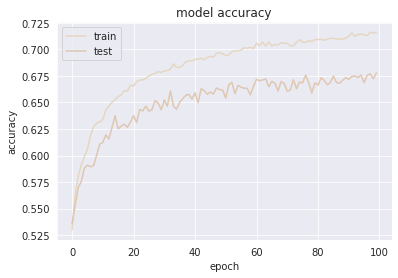

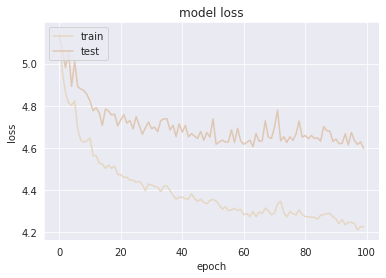

In [103]:
print(model_pca.history.keys())
# summarize history for accuracy
plt.plot(model_pca.history['accuracy'])
plt.plot(model_pca.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_pca.history['loss'])
plt.plot(model_pca.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Selected features

In [96]:
input_shape = (X_train_sf.shape[1],)
print('input shape = ', input_shape)
hypermodel = ClassificationHyperModel(input_shape)

tuner = RandomSearch(
            hypermodel,
            objective='accuracy',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True)
  
tuner.search(X_train_sf, Y_train_sf, epochs=10, validation_split=.2, verbose=1)
best_model = tuner.get_best_models(num_models=1)[0]
model_sf = best_model.fit(X_train_sf, Y_train_sf,  validation_data=(X_test_sf, Y_test_sf), batch_size=5, epochs=100, verbose=1)
_, train_acc_sf = best_model.evaluate(X_train_sf, Y_train_sf, verbose=1)
_, test_acc_sf = best_model.evaluate(X_test_sf, Y_test_sf, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc_sf, test_acc_sf))

Trial 10 Complete [00h 00m 51s]
accuracy: 0.3745228946208954

Best accuracy So Far: 0.5907640159130096
Total elapsed time: 00h 08m 53s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
7599/7599 [==============================] - 21s 3ms/step - loss: 2.5232 - accuracy: 0.4847 - val_loss: 2.1825 - val_accuracy: 0.5046
Epoch 2/100
7599/7599 [==============================] - 21s 3ms/step - loss: 2.0332 - accuracy: 0.5324 - val_loss: 2.0428 - val_accuracy: 0.5228
Epoch 3/100
7599/7599 [==============================] - 21s 3ms/step - loss: 1.8749 - accuracy: 0.5623 - val_loss: 1.9361 - val_accuracy: 0.5536
Epoch 4/100
7599/7599 [==============================] - 22s 3ms/step - loss: 1.7805 - accuracy: 0.5810 - val_loss: 1.8722 - val_accuracy: 0.5687
Epoch 5/100
7599/7599 [==============================] - 21s 3ms/step - loss: 1.7175 - accuracy: 0.5936 - val_loss: 1.8114 - val_accuracy: 0.5848
Epoch 6/100
7599/7599 [==============================] - 21s 3ms/step - loss: 1.6523 - accuracy: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


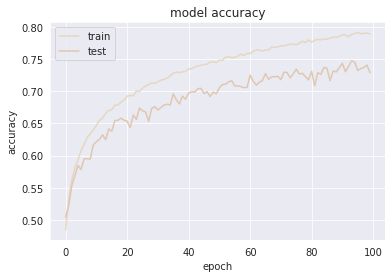

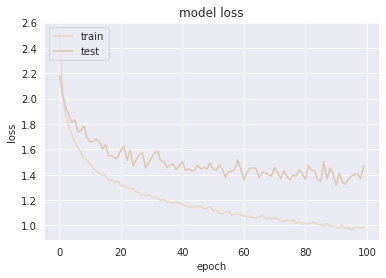

In [104]:
print(model_sf.history.keys())
# summarize history for accuracy
plt.plot(model_sf.history['accuracy'])
plt.plot(model_sf.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_sf.history['loss'])
plt.plot(model_sf.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Only robust features

Так как по заданию нужно обучить на всех имеющихся признаках, то здесь будет наибольшее количество эпох.
Обучим на train выборке, протестируем на test. Итоговое значение точности оценим на всех данных.

Количество нейронов на скрытом слое - 10500, функция активации - Relu.

In [121]:
input_shape = (X_train.shape[1],)
print('input shape = ', input_shape)
hypermodel = ClassificationHyperModel(input_shape)

tuner = RandomSearch(
            hypermodel,
            objective='accuracy',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True)
  
tuner.search(X_train, Y_train, epochs=20, validation_split=.2, verbose=7)
best_model = tuner.get_best_models(num_models=1)[0]
model = best_model.fit(X_train, Y_train,  validation_data=(X_test, Y_test), batch_size=5, epochs=600, verbose=7)
_, train_acc = best_model.evaluate(X_train, Y_train, verbose=1)
_, test_acc = best_model.evaluate(X_test, Y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Trial 10 Complete [00h 01m 29s]
accuracy: 0.6712128221988678

Best accuracy So Far: 0.7231837511062622
Total elapsed time: 00h 15m 39s
INFO:tensorflow:Oracle triggered exit
Epoch 1/600
Epoch 2/600
Epoch 3/600
Epoch 4/600
Epoch 5/600
Epoch 6/600
Epoch 7/600
Epoch 8/600
Epoch 9/600
Epoch 10/600
Epoch 11/600
Epoch 12/600
Epoch 13/600
Epoch 14/600
Epoch 15/600
Epoch 16/600
Epoch 17/600
Epoch 18/600
Epoch 19/600
Epoch 20/600
Epoch 21/600
Epoch 22/600
Epoch 23/600
Epoch 24/600
Epoch 25/600
Epoch 26/600
Epoch 27/600
Epoch 28/600
Epoch 29/600
Epoch 30/600
Epoch 31/600
Epoch 32/600
Epoch 33/600
Epoch 34/600
Epoch 35/600
Epoch 36/600
Epoch 37/600
Epoch 38/600
Epoch 39/600
Epoch 40/600
Epoch 41/600
Epoch 42/600
Epoch 43/600
Epoch 44/600
Epoch 45/600
Epoch 46/600
Epoch 47/600
Epoch 48/600
Epoch 49/600
Epoch 50/600
Epoch 51/600
Epoch 52/600
Epoch 53/600
Epoch 54/600
Epoch 55/600
Epoch 56/600
Epoch 57/600
Epoch 58/600
Epoch 59/600
Epoch 60/600
Epoch 61/600
Epoch 62/600
Epoch 63/600
Epoch 64/600
Epoc

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


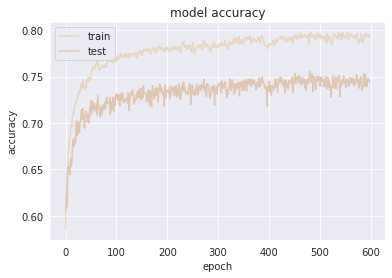

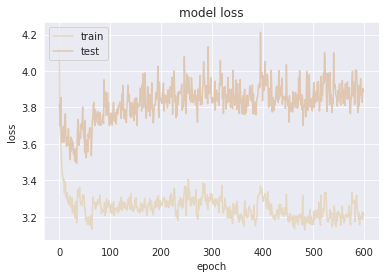

In [124]:
print(model.history.keys())
# summarize history for accuracy
plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [125]:
_, accuracy_res = best_model.evaluate(data.iloc[:, 1:], labels, verbose=1)
print('All data: %.3f' % (accuracy_res))

1697/1697 [==============================] - 3s 2ms/step - loss: 3.3975 - accuracy: 0.7808
All data: 0.781


Все модели дали результат < 0.8, попробуем другой способ работы с признаками.

# Models (normalizer scaling)

In [50]:
from sklearn.preprocessing import Normalizer

normal_features = Normalizer().fit(data.iloc[:, 1:]).transform(data.iloc[:, 1:])

In [51]:
X_train_norm, X_test_norm, Y_train_norm, Y_test_norm = train_test_split(normal_features, labels, test_size=.3, random_state=0)

In [52]:
## мало нейронов (1-100)
input_shape = (X_train.shape[1],)
print('input shape = ', input_shape)
hypermodel = ClassificationHyperModelLow(input_shape)

tuner = RandomSearch(
            hypermodel,
            objective='accuracy',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True)

# params 91 relu
tuner.search(X_train_norm, Y_train_norm, epochs=30, validation_split=.2, verbose=7)
best_model_norm = tuner.get_best_models(num_models=1)[0]
model_norm = best_model_norm.fit(X_train_norm, Y_train_norm,  validation_data=(X_test_norm, Y_test_norm), batch_size=5, epochs=100, verbose=7)
_, train_acc = best_model_norm.evaluate(X_train_norm, Y_train_norm, verbose=1)
_, test_acc = best_model_norm.evaluate(X_test_norm, Y_test_norm, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Trial 10 Complete [00h 02m 10s]
accuracy: 0.20694591104984283

Best accuracy So Far: 0.3233087658882141
Total elapsed time: 00h 21m 33s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epo

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


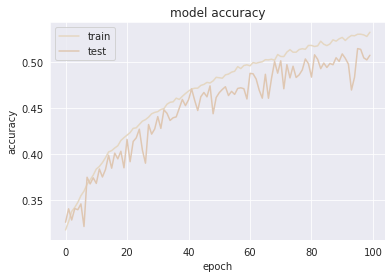

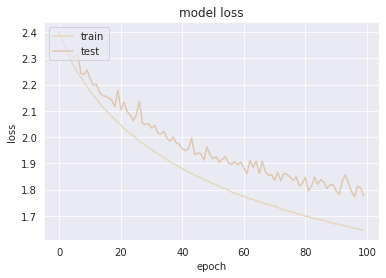

In [53]:
print(model_norm.history.keys())
# summarize history for accuracy
plt.plot(model_norm.history['accuracy'])
plt.plot(model_norm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_norm.history['loss'])
plt.plot(model_norm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [54]:
_, accuracy_res = best_model_norm.evaluate(normal_features, labels, verbose=1)
print('All data: %.3f' % (accuracy_res))

1697/1697 [==============================] - 3s 2ms/step - loss: 1.6617 - accuracy: 0.5288
All data: 0.529


In [129]:
# для 1000 - 20 000 нейронов на скрытом слое
input_shape = (X_train.shape[1],)
print('input shape = ', input_shape)
hypermodel = ClassificationHyperModel(input_shape)

tuner = RandomSearch(
            hypermodel,
            objective='accuracy',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True)

# params 18400 relu
tuner.search(X_train_norm, Y_train_norm, epochs=30, validation_split=.2, verbose=7)
best_model_norm = tuner.get_best_models(num_models=1)[0]
model_norm = best_model_norm.fit(X_train_norm, Y_train_norm,  validation_data=(X_test_norm, Y_test_norm), batch_size=5, epochs=100, verbose=7)
_, train_acc = best_model_norm.evaluate(X_train_norm, Y_train_norm, verbose=1)
_, test_acc = best_model_norm.evaluate(X_test_norm, Y_test_norm, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Trial 10 Complete [00h 02m 08s]
accuracy: 0.45240524411201477

Best accuracy So Far: 0.8205448985099792
Total elapsed time: 00h 23m 02s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epo

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


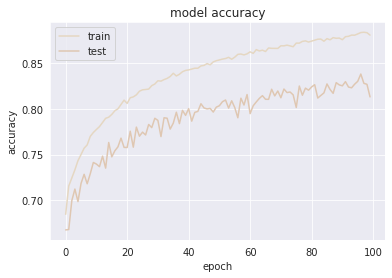

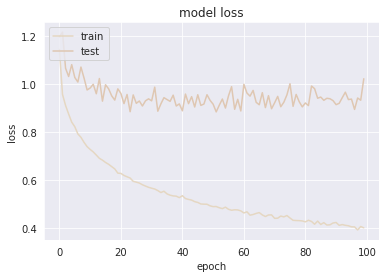

In [130]:
print(model_norm.history.keys())
# summarize history for accuracy
plt.plot(model_norm.history['accuracy'])
plt.plot(model_norm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_norm.history['loss'])
plt.plot(model_norm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [131]:
_, accuracy_res = best_model_norm.evaluate(normal_features, labels, verbose=1)
print('All data: %.3f' % (accuracy_res))

1697/1697 [==============================] - 3s 2ms/step - loss: 0.6268 - accuracy: 0.8551
All data: 0.855


## Feature selection for norm.features

In [11]:
normal_data = data.copy()
normal_data.iloc[:, 1:] = Normalizer().fit(data.iloc[:, 1:]).transform(data.iloc[:, 1:])

In [12]:
corr = normal_data.corr(method ='spearman')

top_corr = corr['class'].sort_values(ascending=False).to_frame()
table_corr = top_corr.style.background_gradient(cmap=cmap)
table_corr

,class
class,1.000000
X_23,0.205657
X_22,0.205426
X_7,0.198918
Y_23,0.186117
X_9,0.179151
Y_22,0.176489
X_11,0.172129
X_6,0.077181
X_14,0.066911


In [13]:
abs_corr = top_corr.apply(lambda row: abs(row))
abs_corr = abs_corr['class'].sort_values(ascending=False).to_frame()[:24]
corr_features = abs_corr.index.to_list()
corr_features 

['class',
 'Y_12',
 'Y_13',
 'Y_14',
 'Y_15',
 'Y_16',
 'Y_0',
 'Y_17',
 'Y_18',
 'Y_19',
 'Y_1',
 'Y_6',
 'Y_4',
 'X_23',
 'X_22',
 'Y_2',
 'X_7',
 'Y_23',
 'Y_3',
 'X_9',
 'Y_8',
 'Y_22',
 'X_11',
 'Y_5']

In [14]:
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=24, step=10, verbose=5)
rfe_selector.fit(data.iloc[:, 1:], data['class'])
rfe_support = rfe_selector.get_support()
rfe_features = data.drop(['class'], axis=1).loc[:,rfe_support].columns.tolist()
print('Топ-24 признаков, отобранных RFE: ', rfe_features)

Fitting estimator with 48 features.
Fitting estimator with 38 features.
Fitting estimator with 28 features.
Топ-24 признаков, отобранных RFE:  ['Y_1', 'X_2', 'Y_3', 'X_4', 'X_5', 'X_6', 'Y_6', 'X_7', 'Y_7', 'X_8', 'Y_8', 'X_10', 'Y_10', 'X_11', 'Y_11', 'Y_12', 'X_13', 'X_14', 'Y_16', 'Y_17', 'X_18', 'X_19', 'X_23', 'Y_23']


In [15]:
selected_features_norm = list(set(corr_features) & set(rfe_features))
selected_features_norm

['Y_6',
 'Y_17',
 'Y_23',
 'Y_1',
 'X_7',
 'Y_12',
 'Y_3',
 'Y_8',
 'X_23',
 'Y_16',
 'X_11']

## Model 

In [16]:
X_train_norm_sf, X_test_norm_sf, Y_train_norm_sf, Y_test_norm_sf = train_test_split(normal_data[selected_features_norm], labels, test_size=.3, random_state=0)

In [19]:
input_shape = (X_train_norm_sf.shape[1],)
print('input shape = ', input_shape)
hypermodel = ClassificationHyperModel(input_shape)

tuner_norm_sf = RandomSearch(
            hypermodel,
            objective='accuracy',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True)

# params 18400 relu
tuner_norm_sf.search(X_train_norm_sf, Y_train_norm_sf, epochs=30, validation_split=.2, verbose=7)
best_model_norm_sf = tuner_norm_sf.get_best_models(num_models=1)[0]
model_norm_sf = best_model_norm_sf.fit(X_train_norm_sf, Y_train_norm_sf,  validation_data=(X_test_norm_sf, Y_test_norm_sf), batch_size=5, epochs=100, verbose=7)
_, train_acc_norm_sf = best_model_norm_sf.evaluate(X_train_norm_sf, Y_train_norm_sf, verbose=1)
_, test_acc_norm_sf = best_model_norm_sf.evaluate(X_test_norm_sf, Y_test_norm_sf, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc_norm_sf, test_acc_norm_sf))

Trial 10 Complete [00h 02m 23s]
accuracy: 0.15262240171432495

Best accuracy So Far: 0.43977034091949463
Total elapsed time: 00h 24m 34s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Ep

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


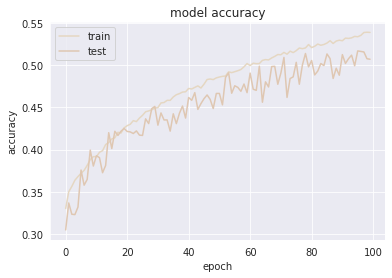

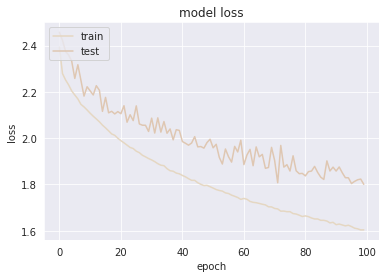

In [21]:
print(model_norm_sf.history.keys())
# summarize history for accuracy
plt.plot(model_norm_sf.history['accuracy'])
plt.plot(model_norm_sf.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_norm_sf.history['loss'])
plt.plot(model_norm_sf.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
_, accuracy_res = best_model_norm_sf.evaluate(normal_data[selected_features_norm], labels, verbose=1)
print('All data: %.3f' % (accuracy_res))

1697/1697 [==============================] - 3s 2ms/step - loss: 1.6258 - accuracy: 0.5321
All data: 0.532


# Model for low number 

In [38]:
class ClassificationHyperModelLow(HyperModel):

    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):

        model = Sequential()
        model.add(
            Dense(units=hp.Int('units',
                                  min_value=1,
                                  max_value=100,
                                  step=1), 
                    
                    input_shape = input_shape,
                    activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu'),
                    kernel_initializer='he_uniform'))
                
        model.add(Dense(40, activation='softmax'))
        model.compile(loss='kullback_leibler_divergence', optimizer='adam', metrics=['accuracy'])
        
        return model

In [42]:
input_shape = (X_train_norm.shape[1],)
print('input shape = ', input_shape)
hypermodel = ClassificationHyperModelLow(input_shape)

tuner = RandomSearch(
            hypermodel,
            objective='accuracy',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True)

# params 97 relu
tuner.search(X_train_norm, Y_train_norm, epochs=30, validation_split=.2, verbose=7)
best_model_norm = tuner.get_best_models(num_models=1)[0]
model_norm = best_model_norm.fit(X_train_norm, Y_train_norm,  validation_data=(X_test_norm, Y_test_norm), batch_size=5, epochs=100, verbose=7)
_, train_acc = best_model_norm.evaluate(X_train_norm, Y_train_norm, verbose=1)
_, test_acc = best_model_norm.evaluate(X_test_norm, Y_test_norm, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Trial 10 Complete [00h 02m 11s]
accuracy: 0.20349104702472687

Best accuracy So Far: 0.32470715045928955
Total elapsed time: 00h 21m 45s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Ep

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


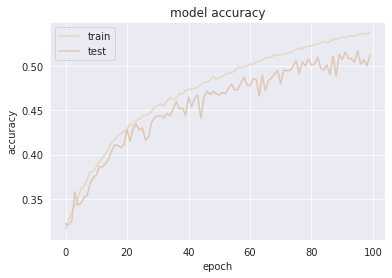

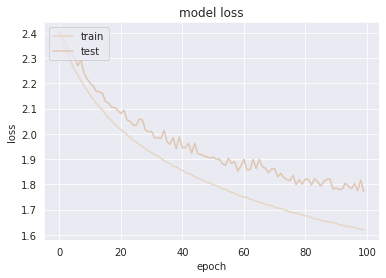

In [43]:
print(model_norm.history.keys())
# summarize history for accuracy
plt.plot(model_norm.history['accuracy'])
plt.plot(model_norm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_norm.history['loss'])
plt.plot(model_norm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
_, accuracy_res = best_model_norm.evaluate(normal_features, labels, verbose=1)
print('All data: %.3f' % (accuracy_res))

1697/1697 [==============================] - 3s 2ms/step - loss: 1.6545 - accuracy: 0.5341
All data: 0.534


# Original data

In [45]:
# запускалось отдельно, поэтому здесь к данным еще не применось робустное скалирование
X_train, X_test, Y_train, Y_test = train_test_split(data.iloc[:, 1:], labels, test_size=.3, random_state=0)

In [ ]:
input_shape = (X_train.shape[1],)
print('input shape = ', input_shape)
hypermodel = ClassificationHyperModel(input_shape)

tuner = RandomSearch(
            hypermodel,
            objective='accuracy',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True)

# params 8800  tanh 
tuner.search(X_train, Y_train, epochs=30, validation_split=.2, verbose=7)
best_model = tuner.get_best_models(num_models=1)[0]
model = best_model.fit(X_train, Y_train,  validation_data=(X_test, Y_test), batch_size=5, epochs=100, verbose=7)
_, train_acc = best_model.evaluate(X_train, Y_train, verbose=1)
_, test_acc = best_model.evaluate(X_test, Y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

In [47]:
_, train_acc = best_model.evaluate(X_train, Y_train, verbose=1)
_, test_acc = best_model.evaluate(X_test, Y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

509/509 [==============================] - 1s 2ms/step - loss: 15.9023 - accuracy: 0.0134
Train: 0.015, Test: 0.013


In [49]:
_, accuracy_res = best_model_norm.evaluate(data.iloc[:, 1:], labels, verbose=1)
print('All data: %.3f' % (accuracy_res))

1697/1697 [==============================] - 3s 2ms/step - loss: 13.6429 - accuracy: 0.1535
All data: 0.154


**Итог работы**

Данные масштабированы двумя способами, лучший результат был получен при масштабировании с помощью Normalizer. Результаты всех измерений представлены в таблице ниже.

<table>
<thead>
<tr><th>Способ масштабирования</th><th>PCA</th><th>Информативные признаки</th><th>Полный набор</th></tr>
</thead>
<tbody>
<tr><td>robust</td><td>Train: 0.722, Test: 0.678 </td><td>Train: 0.787, Test: 0.729</td><td>Train: 0.796, Test: 0.745</td></tr>
<tr><td>normalizer</td><td>-</td><td>Train: 0.543, Test: 0.507</td><td>Train: 0.873, Test: 0.813</td></tr>
</tbody>
</table>

При робустном скалировании признаков лучшее качество удалось получить на полном наборе данных, худшее - с использованием PCA. 

При нормализированном масштабировании лучшее качество на полном наборе данных - для всех признаков accuracy составила 0.855 (в таблице приведены только train/test). PCA для нормализированного масштабирования не использовался, так как он показал худшее качество для робустных и из-за ограничений времени по выполнению работы протестировать не предоставилось возможным.

Для итового анализа будем рассматривать только последнюю строку в таблице.

Количество нейронов на скрытом слое и функция активации в результате отбора случайным поиском для признаков и полного набора совпали (18400, relu), однако точность заметно лучше на полном наборе (0.855 против 0.532).

Задача определения количества нейронов на скрытом слое не является решённой. Обычно рекомендуют следующие первичные действия:
- Количество скрытых нейронов должно быть между размером входного слоя и размером выходного слоя.
- Количество скрытых нейронов должно составлять 2/3 размера входного слоя плюс размер выходного слоя.
- Количество скрытых нейронов должно быть менее чем в два раза больше размера входного слоя.
В данной задаче был осуществлен перебор разного количества нейронов на скрытом слое (1-100, 1000 до 20 000). **Лучший результат был получен для 18400, relu + normalized** (как было отмечено выше). Опираясь на результаты измерений для робустных фич - чем меньше подается на вход признаков, тем меньше нейронов на скрытом слое должно быть (18 400 для полного, 13 400 для информативных признаков, точность примерно одинаковая). В случае нормализованных фич, количество нейронов совпадает, но признаков разное количество, и мы видим сильное различие в качестве работы. Это также может быть вызвано результатом отбора признаков, так как списки выбранных признаков для робустных/нормализованных фич не совпадают (отбор производился после масштабирования).

В случае небольшого количества нейронов, которое удовлетворяло бы условиям выше (отбиралось число между 1 и 100) получены следующие результаты:
- **точность 0.534 для 97 нейронов на скрытом слое без масштабирования,**
- **точность 0.154 для 8800 нейронов на скрытом слое без масштабирования,**
- **точность 0.529 для 91 нейрона на скрытом слое, признаки масштабируемы Normalized.** 

В случае немасштабируемых признаков лучшее значение точности получено для меньшего количества нейронов.

Конечно, слишком большое количество нейронов на скрытом слое - плохо, так как может возникнуть переобучение, но судя по графикам train-test для точности/эпохи здесь переобучения не возникло.
